In [1]:
import os
import sys 
import tensorflow as tf 
import pandas as pd 
import cv2
import numpy as np
import matplotlib.pyplot as plt 

tf.random.set_seed(12)

2023-07-20 15:33:43.777532: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 15:33:43.818934: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 15:33:43.819999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 15:33:44.933826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataset Preparation 

In [2]:
path = "../data/val/val/indoors/"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask":  [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42)

In [3]:
df.head()

,image,depth,mask
234,../data/val/val/indoors/scene_00021/scan_00188...,../data/val/val/indoors/scene_00021/scan_00188...,../data/val/val/indoors/scene_00021/scan_00188...
110,../data/val/val/indoors/scene_00020/scan_00185...,../data/val/val/indoors/scene_00020/scan_00185...,../data/val/val/indoors/scene_00020/scan_00185...
248,../data/val/val/indoors/scene_00021/scan_00189...,../data/val/val/indoors/scene_00021/scan_00189...,../data/val/val/indoors/scene_00021/scan_00189...
9,../data/val/val/indoors/scene_00019/scan_00183...,../data/val/val/indoors/scene_00019/scan_00183...,../data/val/val/indoors/scene_00019/scan_00183...
93,../data/val/val/indoors/scene_00020/scan_00184...,../data/val/val/indoors/scene_00020/scan_00184...,../data/val/val/indoors/scene_00020/scan_00184...


### Data Pipeline 

In [4]:
import albumentations as A

def albu_transform_train():
    return A.Compose([A.RandomRotate90(p=0.1),
                      A.Transpose(p=0.5),
                      A.Blur(p=0.01, blur_limit = 3),
                      A.OneOf([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)],p=0.8)
                      ],p=1)

def albu_transform_valid():
    return A.Compose([A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.1)])

In [5]:
from tensorflow.keras.utils import Sequence

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024),transform = None , n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.to_list()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.augmentation = transform
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index+1)*self.batch_size >len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)
        return x, y
    
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def read_image(self,image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,self.dim)
        return image
    
    def load_depth_map(self,depth_map,mask):

        depth_map = np.load(depth_map).squeeze()
        mask = np.load(mask)
        mask = mask>0
        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        return depth_map


    def load(self,image_path,depth_map,mask):
        image = self.read_image(image_path)
        image = tf.image.convert_image_dtype(image,tf.float32)
        
        depth_map = self.load_depth_map(depth_map,mask)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
        
        return image,depth_map
    
    def data_generation(self,batch):
        x = np.empty((self.batch_size, *self.dim,self.n_channels))
        y = np.empty((self.batch_size,  *self.dim , 1))
        for i , batch_id in enumerate(batch):
            if self.augmentation :
                image_ = self.data["image"][batch_id]
                depth_ = self.data["depth"][batch_id]
                mask_ = self.data["mask"][batch_id]
                
                image = self.read_image(image_)
                depth = self.load_depth_map(depth_,mask_)
                transformed = self.augmentation(image = image, mask = depth)

                transformed_image = tf.image.convert_image_dtype(transformed['image'],tf.float32)
                transformed_depth = tf.image.convert_image_dtype(transformed['mask'],tf.float32)
                x[i,] , y[i,] = transformed_image,transformed_depth

            else:
                x[i,] , y[i,] = self.load(self.data["image"][batch_id],
                                        self.data["depth"][batch_id],
                                        self.data["mask"][batch_id],
                                        )
        return x,y 

## Visualizing samples

2023-07-20 15:33:48.621483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-20 15:33:48.663831: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


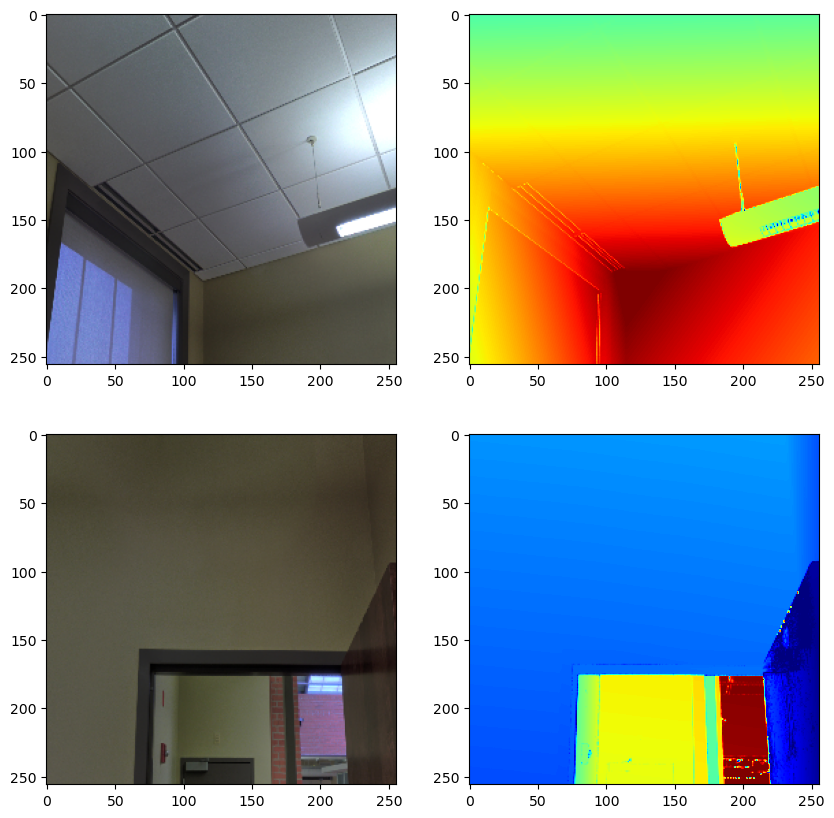

In [6]:
def display_image_mask(train_generator, num_images=4):
    plt.figure(figsize=(10, 10))
    count = 0
    cmap = plt.cm.jet
    for i in range(num_images):
        Xtest, ytest = train_generator.__getitem__(i*np.random.randint(low=5,high=10))

        output_img = ytest[0, :, :, 0]
        if count >= num_images: break
        count += 1
        plt.subplot(2, 2, count)
        plt.imshow(Xtest[0]) # 128x128x3
        count += 1
        plt.subplot(2, 2, count)
        plt.imshow(output_img,cmap=cmap)

HEIGHT = 256
WIDTH = 256

train_gen = DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH))
display_image_mask(train_gen,)

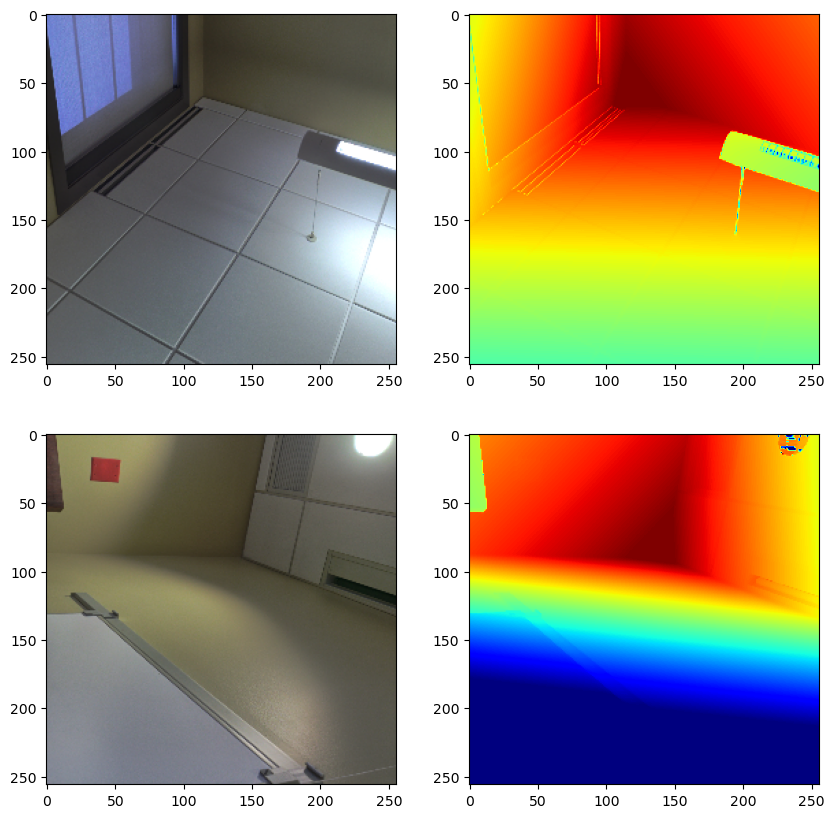

In [7]:
train_gen = DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH),transform=albu_transform_train())
display_image_mask(train_gen,)

## 3D Point cloud Visualization

In [8]:
samples = next(iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH))))
print(samples[1][1].shape)
print(samples[0][1].shape)

(256, 256, 1)
(256, 256, 3)


In [9]:
visulaize_3d = False 

depth_vis = np.flipud(samples[1][1].squeeze())
img_vis = np.flipud(samples[0][1].squeeze())

print(depth_vis.shape,img_vis.shape)
STEP = 3

if visulaize_3d:    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")

    for x in range(0, img_vis.shape[0], STEP):
        for y in range(0, img_vis.shape[1], STEP):
            ax.scatter(
                [depth_vis[x, y]] * 3,
                [y] * 3,
                [x] * 3,
                c=tuple(img_vis[x, y, :3] / 255),
                s=3,
            )
        ax.view_init(45, 135)

(256, 256) (256, 256, 3)


## Model 

In [10]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate 
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam , SGD

In [11]:
class UpscaleBlock(Model):
    def __init__(self,filters,name):
        super(UpscaleBlock,self).__init__()
        self.up = UpSampling2D(size=(2,2),interpolation='bilinear', name=name+'_upsampling2d')
        self.concat = Concatenate(name=name+'_concat') 
        self.convA = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')
        self.reluA = LeakyReLU(alpha=0.2)
        self.convB = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')
        self.reluB = LeakyReLU(alpha=0.2)

    def call(self, x):        
        b = self.reluB( self.convB( self.reluA( self.convA( self.concat( [self.up(x[0]), x[1]] ) ) ) ) )
        return b 

class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__() 
        self.base_model = DenseNet169(input_shape= (None,None,3),include_top = False,weights='imagenet')
        print('Base model loaded {}'.format(DenseNet169.__name__))

        # Create encoder model that produce final features along with multiple intermediate features
        outputs = [self.base_model.outputs[-1]]
        for name in ['pool1', 'pool2_pool', 'pool3_pool', 'conv1/relu'] : outputs.append( self.base_model.get_layer(name).output )        
        self.encoder = Model(inputs=self.base_model.inputs, outputs=outputs)
    
    def call(self, x):
        return self.encoder(x)
    
class Decoder(Model):
    def __init__(self, decode_filters):
        super(Decoder, self).__init__()        
        self.conv2 =  Conv2D(filters=decode_filters, kernel_size=1, padding='same', name='conv2')        
        self.up1 = UpscaleBlock(filters=decode_filters//2,  name='up1')
        self.up2 = UpscaleBlock(filters=decode_filters//4,  name='up2')
        self.up3 = UpscaleBlock(filters=decode_filters//8,  name='up3')
        self.up4 = UpscaleBlock(filters=decode_filters//16, name='up4')        
        self.conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')       
    
    def call(self, features):        
        x, pool1, pool2, pool3, conv1 = features[0], features[1], features[2], features[3], features[4]
        up0 = self.conv2(x)        
        up1 = self.up1([up0, pool3])        
        up2 = self.up2([up1, pool2])        
        up3 = self.up3([up2, pool1])        
        up4 = self.up4([up3, conv1])        
        return self.conv3( up4 )


class DepthEstimate(Model):
    def __init__(self):
        super(DepthEstimate, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder( decode_filters = int(self.encoder.layers[-1].output[0].shape[-1] // 2 ) )
        print('\nModel created.')
    
    def call(self, x):
        return self.decoder( self.encoder(x) )

### Loss 

In [12]:
from tensorflow.keras import backend  as K 
import tensorflow as tf

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    # Point-wise depth
    l_depth =K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta
    # return (w1 * l_ssim) + (w3 * K.mean(l_depth)) + (w2 * K.mean(l_edges)) 
    return K.mean(l_depth)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


def scale_invarient_loss(y_true,y_pred):
    """
    computes scale invarient loss based on log of differences of there depth maps 

    """
    w1 = 1.0
    log_diff = K.log(y_pred.+1) - K.log(y_true+1)
    num_pixels = tf.size(log_diff)
    num_pixels = tf.cast(num_pixels,tf.float32)

    loss = K.sum(K.square(log_diff)) /num_pixels - w1*  K.square(K.sum(log_diff))/K.square(num_pixels)
    return loss

SyntaxError: invalid syntax (2025152050.py, line 34)

In [ ]:
import visualkeras

def create_model(existing='', is_twohundred=False, is_halffeatures=True,freeze_layer = False ):
    n_layers = 100
    if len(existing) == 0:
        print('Loading base model (DenseNet)..')
        # # Encoder Layers
        # if is_twohundred:
        #     base_model = applications.densenet.DenseNet201(input_shape=(None, None, 3), include_top=False)
        # else:
        base_model = DenseNet169(input_shape=(256, 256, 3), include_top=False)
        print('Base model loaded.')

        # Starting point for decoder
        base_model_output_shape = base_model.layers[-1].output.shape

        if not freeze_layer:
            for layer in base_model.layers: 
                layer.trainable = True
        else:
            for layer in base_model.layers[n_layers]:
                layer.trainable = False
                
        # Starting number of decoder filters
        if is_halffeatures:
            decode_filters = int(int(base_model_output_shape[-1])/2)
        else:
            decode_filters = int(base_model_output_shape[-1])

        # Define upsampling layer
        def upproject(tensor, filters, name, concat_with):
            up_i = UpSampling2D((2, 2), name=name+'_upsampling2d')(tensor)
            up_i = Concatenate(name=name+'_concat')([up_i, base_model.get_layer(concat_with).output]) # Skip connection
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            return up_i

        # Decoder Layers
        decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=base_model_output_shape, name='conv2')(base_model.output)

        decoder = upproject(decoder, int(decode_filters/2), 'up1', concat_with='pool3_pool')
        decoder = upproject(decoder, int(decode_filters/4), 'up2', concat_with='pool2_pool')
        decoder = upproject(decoder, int(decode_filters/8), 'up3', concat_with='pool1')
        decoder = upproject(decoder, int(decode_filters/16), 'up4', concat_with='conv1/relu')
        decoder = upproject(decoder,int(decode_filters/32),'up5',concat_with='input_1')    
        # if False: 
        # decoder = upproject(decoder, int(decode_filters/32), 'up5', concat_with='input_1')

        # Extract depths (final layer)
        conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')(decoder)
        # Create the model
        model = Model(inputs=base_model.input, outputs=conv3)

    print('Model created.')
    return model

In [ ]:
learning_rate = 0.001
depth_net = create_model(is_halffeatures=False)

print(depth_net.input_shape)
print(depth_net.output_shape)

visualkeras.layered_view(depth_net, legend=True) # selected font

In [ ]:
# optimizer = SGD(momentum=0.9, nesterov=True)
optimizer = Adam(learning_rate=0.001)
depth_net.compile(loss=scale_invarient_loss, optimizer=optimizer)

## Model Training 

In [ ]:
# Create checkpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint

path  = "../data/training_2/"
checkpoint = ModelCheckpoint(os.path.join(path,"depth_model.h5"), monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

### Train without Augmentation

In [ ]:
train_gen = DataGenerator(data=df, batch_size=4, dim=(HEIGHT, WIDTH),transform=None)
EPOCHS = 5 
History = depth_net.fit(
    train_gen,
    epochs=EPOCHS,  
    callbacks=callbacks_list)

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Loss on dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")

### Train with Augmentation 

In [ ]:
train_gen = DataGenerator(data=df, batch_size=4, dim=(HEIGHT, WIDTH),transform=albu_transform_train())
EPOCHS = 5 

History = depth_net.fit(
    train_gen,
    epochs=EPOCHS,  
    callbacks=callbacks_list)

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_acc")
# plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on augmented dataset ")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

### Load model Checkpoint

In [ ]:
## Loading weights 
from tensorflow.keras.models import load_model

# custom_objects = {'BilinearUpSampling2D': UpSampling2D, 'depth_loss_function': depth_loss_function}
model = load_model("../data/training_2/depth_model.h5",custom_objects={'depth_loss_function': depth_loss_function})

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)


In [ ]:
test_loader[1].shape


In [ ]:
def visualize_depth_map(samples, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    pred = model.predict(input)
    fig, ax = plt.subplots(6, 3, figsize=(50, 50))
    for i in range(6):
        ax[i, 0].imshow((input[i].squeeze()))
        ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
        ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

visualize_depth_map(test_loader,model=model)

In [20]:
def equal_sum_subset_partition(nums):
    def backtrack(start, target_sum, current_sum, subset):
        if len(subset) == len(nums) // 2 and current_sum == target_sum:
            subsets.append(subset[:])
            return

        for i in range(start, len(nums)):
            if len(subset) < len(nums) // 2 and current_sum + nums[i] <= target_sum:
                subset.append(nums[i])
                backtrack(i + 1, target_sum, current_sum + nums[i], subset)
                subset.pop()

    total_sum = sum(nums)
    if total_sum % 2 != 0:
        return []

    target_sum = total_sum // 2
    subsets = []
    backtrack(0, target_sum, 0, [])

    return subsets

equal_sum_subset_partition([1,5,5,10])

[]